In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
from quimb.utils import progbar as Progbar
from mpi4py import MPI
import pickle


# torch
from torch.nn.parameter import Parameter
import torch
import torch.nn as nn
torch.autograd.set_detect_anomaly(False)

# quimb
import quimb as qu
import quimb.tensor as qtn
import autoray as ar
from autoray import do

from vmc_torch.experiment.tn_model import fTNModel, fTN_NN_proj_variable_Model
from vmc_torch.experiment.tn_model import fTN_Transformer_Model, fTN_Transformer_Proj_lazy_Model
from vmc_torch.experiment.tn_model import init_weights_xavier, init_weights_kaiming, init_weights_to_zero
from vmc_torch.sampler import MetropolisExchangeSamplerSpinless, MetropolisExchangeSamplerSpinful
from vmc_torch.variational_state import Variational_State
from vmc_torch.optimizer import TrivialPreconditioner, SignedSGD, SGD, SR
from vmc_torch.VMC import VMC
from vmc_torch.hamiltonian import spinful_Fermi_Hubbard_square_lattice, spinless_Fermi_Hubbard_square_lattice
from vmc_torch.torch_utils import SVD,QR
from vmc_torch.utils import closest_divisible
from vmc_torch.fermion_utils import generate_random_fpeps

# Register safe SVD and QR functions to torch
ar.register_function('torch','linalg.svd',SVD.apply)
ar.register_function('torch','linalg.qr',QR.apply)

from vmc_torch.global_var import DEBUG


COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()

# Hamiltonian parameters
Lx = int(4)
Ly = int(4)
symmetry = 'Z2'
t = 1.0
U = 8.0
N_f = int(Lx*Ly-2)
# N_f=12
n_fermions_per_spin = (N_f//2, N_f//2)
H = spinful_Fermi_Hubbard_square_lattice(Lx, Ly, t, U, N_f, pbc=False, n_fermions_per_spin=n_fermions_per_spin)
graph = H.graph
# TN parameters
D = 10
chi = -2
dtype=torch.float64

# Load PEPS
try:
    skeleton = pickle.load(open(f"../../data/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}/peps_skeleton.pkl", "rb"))
    peps_params = pickle.load(open(f"../../data/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}/peps_su_params.pkl", "rb"))
    peps = qtn.unpack(peps_params, skeleton)
except:
    peps = generate_random_fpeps(Lx, Ly, D=D, seed=2, symmetry=symmetry, Nf=N_f, spinless=False)[0]
peps_np = peps.copy()
peps.apply_to_arrays(lambda x: torch.tensor(x, dtype=dtype))

# VMC sample size
N_samples = 2
N_samples = closest_divisible(N_samples, SIZE)

model = fTNModel(peps, max_bond=chi)
model.apply(lambda x: init_weights_to_zero(x, std=2e-2))
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

model_names = {
    fTNModel: 'fTN',
    fTN_Transformer_Model: 'fTN_Transformer',
    fTN_Transformer_Proj_lazy_Model: 'fTN_Transformer_Proj_lazy',
    fTN_NN_proj_variable_Model: 'fTN_NN_proj_variable',
    
}
model_name = model_names.get(type(model), 'UnknownModel')

init_step = 0
total_steps = 200
if init_step != 0:
    saved_model_params = torch.load(f'../../data/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}/{model_name}/chi={chi}/model_params_step{init_step}.pth')
    saved_model_state_dict = saved_model_params['model_state_dict']
    saved_model_params_vec = torch.tensor(saved_model_params['model_params_vec'])
    try:
        model.load_state_dict(saved_model_state_dict)
    except:
        model.load_params(saved_model_params_vec)

# optimizer = SignedSGD(learning_rate=0.05)
optimizer = SGD(learning_rate=0.05)
sampler = MetropolisExchangeSamplerSpinful(H.hilbert, graph, N_samples=N_samples, burn_in_steps=2, reset_chain=False, random_edge=False, equal_partition=True, dtype=dtype)
# sampler = None
variational_state = Variational_State(model, hi=H.hilbert, sampler=sampler, dtype=dtype)
preconditioner = SR(dense=False, exact=True if sampler is None else False, use_MPI4Solver=True, diag_eta=0.05, iter_step=1e5, dtype=dtype)
# preconditioner = TrivialPreconditioner()
vmc = VMC(H, variational_state=variational_state, optimizer=optimizer, preconditioner=preconditioner)

/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import jax
import pyinstrument
random_config = H.hilbert.random_state(key=jax.random.PRNGKey(1))
random_config_np = random_config.copy()
random_config = torch.tensor(random_config, dtype=dtype)
amp = peps.get_amp(random_config)
amp_np = peps_np.get_amp(random_config_np)
# model(random_config), amp.contract(), amp_np.contract()
# %%timeit
amp_np = peps_np.get_amp(random_config_np, contract=True)
with pyinstrument.Profiler() as prof:
    # amp.contract()
    # amp_np.contract()
    # amp_np = amp_np.contract_boundary_from_ymin(max_bond=chi, cutoff=0.0, yrange=[0, amp_np.Ly//2-1])
    # amp_np = amp_np.contract_boundary_from_ymax(max_bond=chi, cutoff=0.0, yrange=[amp_np.Ly//2, amp_np.Ly-1])
    amp_val = amp_np.contract()
prof.print()


  _     ._   __/__   _ _  _  _ _/_   Recorded: 16:07:43  Samples:  11
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.012     CPU time: 0.011
/   _/                      v4.7.3

Profile at /tmp/ipykernel_6900/323716686.py:11

0.011 <module>  ../../../../../tmp/ipykernel_6900/323716686.py:11
└─ 0.011 PEPS.contract  quimb/tensor/tensor_core.py:8438
   └─ 0.011 wrapper  functools.py:883
      └─ 0.011 tensor_contract  quimb/tensor/tensor_core.py:207
         └─ 0.011 array_contract  quimb/tensor/contraction.py:273
            └─ 0.011 array_contract  cotengra/interface.py:735
                  [1 frames hidden]  cotengra
                     0.011 wrapper  functools.py:883
                     └─ 0.011 tensordot_fermionic  symmray/fermionic_core.py:762
                        ├─ 0.009 tensordot_abelian  symmray/abelian_core.py:2347
                        │  └─ 0.009 _tensordot_via_fused  symmray/abelian_core.py:2289
                        │     ├─ 0.005 Z2FermionicArray.fuse  symmray/

In [10]:
with pyinstrument.Profiler() as prof:
    model(random_config)
prof.print()


  _     ._   __/__   _ _  _  _ _/_   Recorded: 16:08:12  Samples:  23
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.024     CPU time: 0.025
/   _/                      v4.7.3

Profile at /tmp/ipykernel_6900/1791513093.py:1

0.023 <module>  ../../../../../tmp/ipykernel_6900/1791513093.py:1
└─ 0.023 fTNModel._wrapped_call_impl  torch/nn/modules/module.py:1732
      [0 frames hidden]  
         0.023 tuple._call_impl  torch/nn/modules/module.py:1740
         └─ 0.023 fTNModel.forward  ../tn_model.py:534
            └─ 0.023 fTNModel.amplitude  ../tn_model.py:867
               ├─ 0.013 fPEPS.get_amp  vmc_torch/fermion_utils.py:148
               │  ├─ 0.011 TensorNetwork.contract  quimb/tensor/tensor_core.py:8438
               │  │  └─ 0.011 TensorNetwork.contract_tags  quimb/tensor/tensor_core.py:8328
               │  │     └─ 0.011 wrapper  functools.py:883
               │  │        └─ 0.011 tensor_contract  quimb/tensor/tensor_core.py:207
               │  │           ├─ 0.010 a

In [5]:
import jax
len(H.H.terms), 
rstate = H.hi.random_state(key=jax.random.PRNGKey(2))
print(len(H.H.get_conn(rstate)[0]))

58


In [14]:
# test expectation value calculation
import pyinstrument
with pyinstrument.Profiler() as prof0:
    variational_state.expect(H)
prof0.print()

Burn-in...
Burn-in time: 2.1198511123657227


Sampling starts for rank 0...: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s, Time per sample for each rank=0.986]
/home/sijingdu/TNVMC/VMC_code/vmc_torch/vmc_torch/variational_state.py:287: RuntimeWarning: divide by zero encountered in scalar divide
  R_hat = np.sqrt(V_hat/W)


RANK0, sample size: 2, chain length per rank: 2
Time for MPI communication: 0.0011389999999664724
R_hat: inf
V_hat:4.739151541229866, OP_var:2.3695757706149343

  _     ._   __/__   _ _  _  _ _/_   Recorded: 17:58:50  Samples:  3933
 /_//_/// /_\ / //_// / //_'/ //     Duration: 4.015     CPU time: 4.053
/   _/                      v4.7.3

Profile at /tmp/ipykernel_19620/1557193656.py:3

4.012 <module>  ../../../../../tmp/ipykernel_19620/1557193656.py:3
└─ 4.012 Variational_State.expect  ../variational_state.py:192
   └─ 4.012 Variational_State.collect_samples  ../variational_state.py:229
      └─ 4.005 MetropolisExchangeSamplerSpinful.sample  ../sampler.py:118
         ├─ 2.120 MetropolisExchangeSamplerSpinful.burn_in  ../sampler.py:108
         │  └─ 2.120 MetropolisExchangeSamplerSpinful._sample_next  ../sampler.py:843
         │     └─ 2.113 wrapper  ../utils.py:39
         │        └─ 2.111 Variational_State.amplitude  ../variational_state.py:87
         │           └─ 2.111 fTNMo

In [15]:
# test burn in
import pyinstrument
with pyinstrument.Profiler() as prof0:
    sampler.burn_in(variational_state)
prof0.print()


  _     ._   __/__   _ _  _  _ _/_   Recorded: 17:58:55  Samples:  747
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.750     CPU time: 0.751
/   _/                      v4.7.3

Profile at /tmp/ipykernel_19620/2309394760.py:3

0.750 <module>  ../../../../../tmp/ipykernel_19620/2309394760.py:3
└─ 0.750 MetropolisExchangeSamplerSpinful.burn_in  ../sampler.py:108
   └─ 0.750 MetropolisExchangeSamplerSpinful._sample_next  ../sampler.py:843
      └─ 0.746 wrapper  ../utils.py:39
         └─ 0.744 Variational_State.amplitude  ../variational_state.py:87
            └─ 0.744 fTNModel._wrapped_call_impl  torch/nn/modules/module.py:1549
                  [0 frames hidden]  
                     0.744 fTNModel._call_impl  torch/nn/modules/module.py:1555
                     └─ 0.743 fTNModel.forward  tn_model.py:534
                        └─ 0.739 fTNModel.amplitude  tn_model.py:867
                           ├─ 0.371 fPEPS.get_amp  ../fermion_utils.py:115
                           │  ├─ 0.3

In [6]:
import jax
import pyinstrument
random_config = H.hilbert.random_state(key=jax.random.PRNGKey(1))
random_config_np = random_config.copy()
random_config = torch.tensor(random_config, dtype=dtype)
amp = peps.get_amp(random_config)
amp_np = peps_np.get_amp(random_config_np)
model(random_config), amp.contract(), amp_np.contract()

/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(tensor([1.0158e+12], dtype=torch.float64, grad_fn=<StackBackward0>),
 tensor(1.0158e+12, dtype=torch.float64),
 1015826584584.5565)

/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:307: UserWarning: Trial error: maximum recursion depth exceeded while calling a Python object. Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
Process ForkProcess-6:
Process ForkProcess-3:
Process ForkProcess-12:
Process ForkProcess-16:
Process ForkProcess-10:
Process ForkProcess-8:
Process ForkProcess-9:
Traceback (most recent call last):
Process ForkProcess-14:
  File "/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/concurrent/futures/process.py", line 240, in _process_worker
    call_item = call_queue.get(block=True)

In [8]:
# %%timeit
amp_np = peps_np.get_amp(random_config_np, contract=True)
with pyinstrument.Profiler() as prof:
    amp_np.contract()
prof.print()


  _     ._   __/__   _ _  _  _ _/_   Recorded: 18:13:18  Samples:  28
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.029     CPU time: 0.029
/   _/                      v4.7.3

Profile at /tmp/ipykernel_13751/4159293548.py:3

0.028 <module>  ../../../../../tmp/ipykernel_13751/4159293548.py:3
└─ 0.028 PEPS.contract  quimb/tensor/tensor_core.py:8438
   └─ 0.028 wrapper  functools.py:883
      └─ 0.028 tensor_contract  quimb/tensor/tensor_core.py:207
         └─ 0.028 array_contract  quimb/tensor/contraction.py:273
            └─ 0.028 array_contract  cotengra/interface.py:735
                  [1 frames hidden]  cotengra
                     0.028 wrapper  functools.py:883
                     └─ 0.028 tensordot_fermionic  symmray/fermionic_core.py:762
                        ├─ 0.019 tensordot_abelian  symmray/abelian_core.py:2347
                        │  └─ 0.019 _tensordot_via_fused  symmray/abelian_core.py:2289
                        │     ├─ 0.005 Z2FermionicArray.fuse  symmra

In [17]:
symmray_arr = amp.arrays[0]

In [20]:
# for ts in amp_np.tensors:
#     print(ts.data)
#     ts.modify(data = ts.data.to_pyblock3())

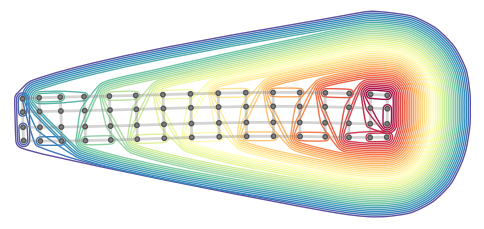

(<Figure size 600x400 with 1 Axes>, <Axes: >)

In [ ]:
tree = amp.contraction_tree()
tree.plot_rubberband(figsize=(6, 4))

In [ ]:
with pyinstrument.Profiler() as prof1:
    with torch.no_grad():
        model(random_config)
prof1.print()


  _     ._   __/__   _ _  _  _ _/_   Recorded: 16:28:27  Samples:  151
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.152     CPU time: 0.153
/   _/                      v4.7.3

Profile at /tmp/ipykernel_8374/2277953694.py:1

0.151 <module>  ../../../../../tmp/ipykernel_8374/2277953694.py:1
└─ 0.151 fTNModel._wrapped_call_impl  torch/nn/modules/module.py:1549
      [0 frames hidden]  
         0.151 fTNModel._call_impl  torch/nn/modules/module.py:1555
         └─ 0.151 fTNModel.forward  tn_model.py:533
            └─ 0.151 fTNModel.amplitude  tn_model.py:785
               ├─ 0.065 PEPS.contract  quimb/tensor/tensor_core.py:8438
               │  └─ 0.065 wrapper  functools.py:883
               │     └─ 0.065 tensor_contract  quimb/tensor/tensor_core.py:207
               │        └─ 0.064 array_contract  quimb/tensor/contraction.py:273
               │           └─ 0.064 array_contract  cotengra/interface.py:735
               │                 [1 frames hidden]  cotengra
        

In [ ]:
# %%timeit
with pyinstrument.Profiler() as prof:
    amp_np = peps_np.get_amp(random_config_np, contract=True)
    amp_np.contract()
prof.print()


  _     ._   __/__   _ _  _  _ _/_   Recorded: 01:40:50  Samples:  103
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.106     CPU time: 0.108
/   _/                      v4.7.3

Profile at /tmp/ipykernel_8374/278286222.py:2

0.105 <module>  ../../../../../tmp/ipykernel_8374/278286222.py:2
├─ 0.053 PEPS.contract  quimb/tensor/tensor_core.py:8438
│  └─ 0.053 wrapper  functools.py:883
│     └─ 0.053 tensor_contract  quimb/tensor/tensor_core.py:207
│        └─ 0.052 array_contract  quimb/tensor/contraction.py:273
│           └─ 0.052 array_contract  cotengra/interface.py:735
│                 [1 frames hidden]  cotengra
│                    0.051 wrapper  functools.py:883
│                    └─ 0.051 tensordot_fermionic  symmray/fermionic_core.py:762
│                       ├─ 0.037 tensordot_abelian  symmray/abelian_core.py:2347
│                       │  └─ 0.037 _tensordot_via_fused  symmray/abelian_core.py:2289
│                       │     ├─ 0.014 U1FermionicArray.fuse  symmray/a

In [ ]:
# %%timeit
# with torch.no_grad():
# with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
with pyinstrument.Profiler() as prof0:
    with torch.no_grad():
        amp = peps.get_amp(random_config, contract=True)
        amp.contract()
# print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))
prof0.print()


  _     ._   __/__   _ _  _  _ _/_   Recorded: 01:34:59  Samples:  130
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.131     CPU time: 0.131
/   _/                      v4.7.3

Profile at /tmp/ipykernel_8374/2876882166.py:4

0.130 <module>  ../../../../../tmp/ipykernel_8374/2876882166.py:4
├─ 0.066 PEPS.contract  quimb/tensor/tensor_core.py:8438
│  └─ 0.066 wrapper  functools.py:883
│     └─ 0.066 tensor_contract  quimb/tensor/tensor_core.py:207
│        └─ 0.065 array_contract  quimb/tensor/contraction.py:273
│           └─ 0.065 array_contract  cotengra/interface.py:735
│                 [1 frames hidden]  cotengra
│                    0.065 wrapper  functools.py:883
│                    └─ 0.064 tensordot_fermionic  symmray/fermionic_core.py:762
│                       ├─ 0.042 tensordot_abelian  symmray/abelian_core.py:2347
│                       │  └─ 0.041 _tensordot_via_fused  symmray/abelian_core.py:2289
│                       │     ├─ 0.016 U1FermionicArray.fuse  symmray

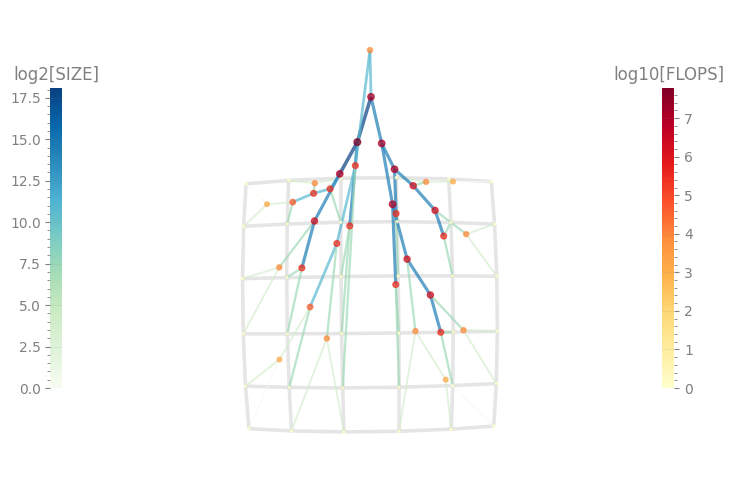

(<Figure size 600x600 with 3 Axes>, <Axes: >)

In [ ]:
tree.plot_tent(figsize=(6, 6))

In [ ]:
amp.arrays[0]

U1FermionicArray(shape~(3, 2):[++], charge=1, num_blocks=2)

In [ ]:
with pyinstrument.Profiler() as prof:
    model(random_config)
prof.print()


  _     ._   __/__   _ _  _  _ _/_   Recorded: 15:44:11  Samples:  176
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.178     CPU time: 0.179
/   _/                      v4.7.3

Profile at /tmp/ipykernel_4515/1791513093.py:1

0.178 <module>  ../../../../../tmp/ipykernel_4515/1791513093.py:1
└─ 0.178 fTNModel._wrapped_call_impl  torch/nn/modules/module.py:1549
      [0 frames hidden]  
         0.178 fTNModel._call_impl  torch/nn/modules/module.py:1555
         └─ 0.178 fTNModel.forward  tn_model.py:532
            └─ 0.177 fTNModel.amplitude  tn_model.py:783
               ├─ 0.077 fPEPS.get_amp  ../fermion_utils.py:116
               │  ├─ 0.071 TensorNetwork.contract  quimb/tensor/tensor_core.py:8438
               │  │  └─ 0.071 TensorNetwork.contract_tags  quimb/tensor/tensor_core.py:8328
               │  │     ├─ 0.067 wrapper  functools.py:883
               │  │     │  └─ 0.067 tensor_contract  quimb/tensor/tensor_core.py:207
               │  │     │     └─ 0.066 array_cont